#### Dont use this code (Old Version)

[0.54199389]


In [23]:
#import numpy as np
import random
import heapq
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import copy

#### Ward simulation

The plot below shows bed occupancy over time for each ward during the burn-in period.

[0.54199389]


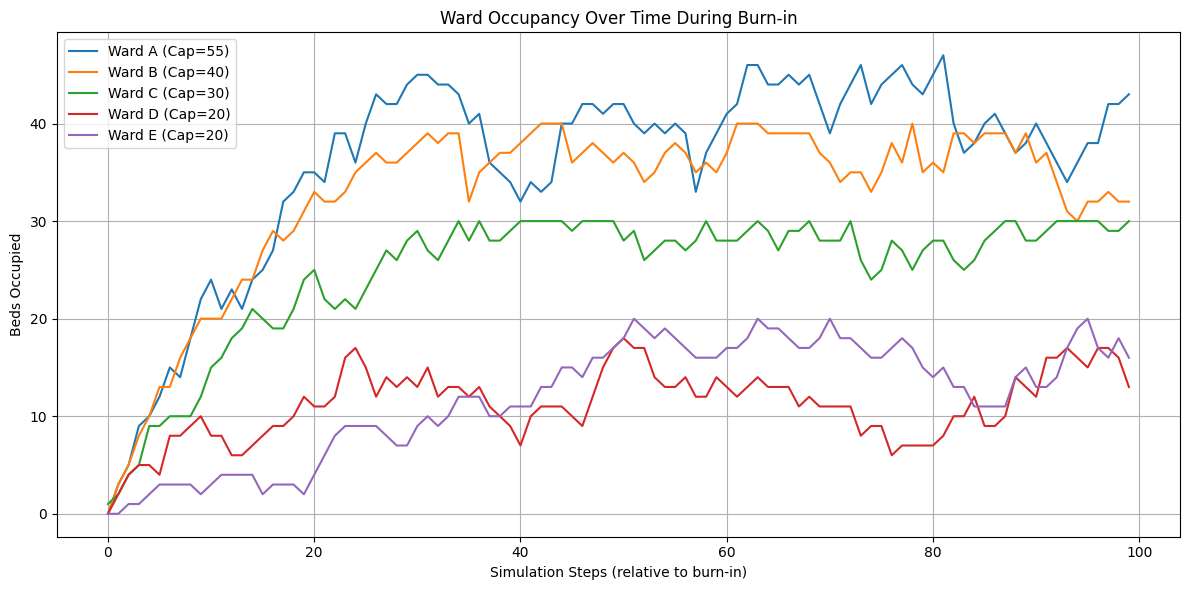

In [31]:
import numpy as np

# Create a Generator using MT19937
bitgen = np.random.MT19937(seed=42)
rng = np.random.Generator(bitgen)

# Use this generator to sample
print(rng.uniform(0, 1, 1))  # Now uses seeded MT19937

def simulate_burnin_occupancy(n=3000, burn_in=1000, capacity=None, lambda_rates=None, mu_rates=None, P=None, track_time=100):
    """
    Simulates hospital ward occupancy over time to determine burn-in period.
    Returns occupancy time series for each ward.
    """
    if capacity is None:
        capacity = [55, 40, 30, 20, 20]
    if lambda_rates is None:
        lambda_rates = [14.5, 11.0, 8.0, 6.5, 5.0]
    if mu_rates is None:
        mu_rates = [1/2.9, 1/4.0, 1/4.5, 1/1.4, 1/3.9]
    if P is None:
        P = np.array([
            [0.0, 0.05, 0.10, 0.05, 0.80],
            [0.20, 0.0, 0.50, 0.15, 0.15],
            [0.30, 0.20, 0.0, 0.20, 0.30],
            [0.35, 0.30, 0.05, 0.0, 0.30],
            [0.20, 0.10, 0.60, 0.10, 0.0]
        ])
        

    m = len(capacity)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # initialize all usable beds to free

    occupancy_time_series = [[] for _ in range(m)]
    current_time = 0

    for i in range(burn_in):
        arrival_time = np.random.exponential(1 / sum(lambda_rates))
        current_time += arrival_time
        beds = np.where(np.isnan(beds), np.nan, beds - arrival_time)

        patient_type = np.random.choice(m, p=np.array(lambda_rates) / sum(lambda_rates))
        assigned_ward = patient_type
        los = np.random.exponential(1 / mu_rates[patient_type])

        bed_index = np.nanargmin(beds[assigned_ward])
        bed_time = beds[assigned_ward, bed_index]

        if bed_time <= 0:
            beds[assigned_ward, bed_index] = los
        else:
            assigned_ward = np.random.choice(m, p=P[patient_type])
            bed_index = np.nanargmin(beds[assigned_ward])
            bed_time = beds[assigned_ward, bed_index]
            if bed_time <= 0:
                beds[assigned_ward, bed_index] = los
            # else lost (not tracked here)

        if i % (burn_in // track_time) == 0:
            for j in range(m):
                occ = np.sum(beds[j, :] > 0)
                occupancy_time_series[j].append(occ)

    return occupancy_time_series, capacity

# Run and plot
occupancy_time_series, capacity = simulate_burnin_occupancy()
wards = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(12, 6))
for i, series in enumerate(occupancy_time_series):
    plt.plot(series, label=f"Ward {wards[i]} (Cap={capacity[i]})")
plt.xlabel("Simulation Steps (relative to burn-in)")
plt.ylabel("Beds Occupied")
plt.title("Ward Occupancy Over Time During Burn-in")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

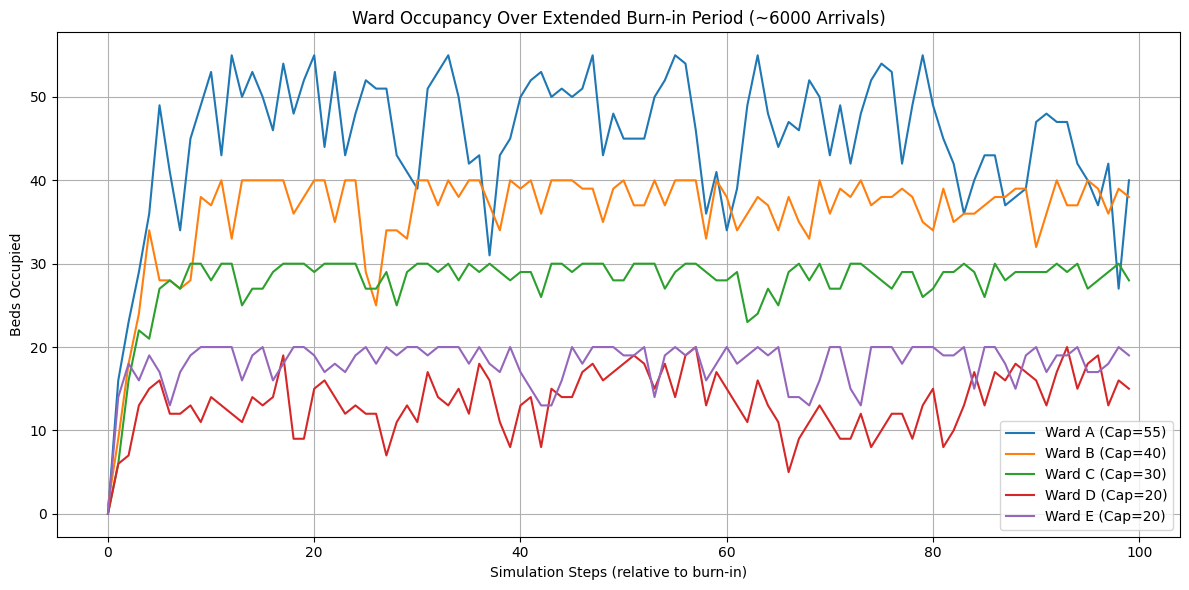

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_burnin_occupancy(n=6000, burn_in=6000, capacity=None, lambda_rates=None, mu_rates=None, P=None, track_time=100):
    """
    Simulates hospital ward occupancy over time to determine burn-in period.
    Returns occupancy time series for each ward.
    """
    if capacity is None:
        capacity = [55, 40, 30, 20, 20]
    if lambda_rates is None:
        lambda_rates = [14.5, 11.0, 8.0, 6.5, 5.0]
    if mu_rates is None:
        mu_rates = [1/2.9, 1/4.0, 1/4.5, 1/1.4, 1/3.9]
    if P is None:
        P = np.array([
            [0.0, 0.05, 0.10, 0.05, 0.80],
            [0.20, 0.0, 0.50, 0.15, 0.15],
            [0.30, 0.20, 0.0, 0.20, 0.30],
            [0.35, 0.30, 0.05, 0.0, 0.30],
            [0.20, 0.10, 0.60, 0.10, 0.0]
        ])

    m = len(capacity)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # initialize all usable beds to free

    occupancy_time_series = [[] for _ in range(m)]
    current_time = 0

    for i in range(burn_in):
        arrival_time = np.random.exponential(1 / sum(lambda_rates))
        current_time += arrival_time
        beds = np.where(np.isnan(beds), np.nan, beds - arrival_time)

        patient_type = np.random.choice(m, p=np.array(lambda_rates) / sum(lambda_rates))
        assigned_ward = patient_type
        los = np.random.exponential(1 / mu_rates[patient_type])

        bed_index = np.nanargmin(beds[assigned_ward])
        bed_time = beds[assigned_ward, bed_index]

        if bed_time <= 0:
            beds[assigned_ward, bed_index] = los
        else:
            assigned_ward = np.random.choice(m, p=P[patient_type])
            bed_index = np.nanargmin(beds[assigned_ward])
            bed_time = beds[assigned_ward, bed_index]
            if bed_time <= 0:
                beds[assigned_ward, bed_index] = los
            # else lost (not tracked here)

        if i % (burn_in // track_time) == 0:
            for j in range(m):
                occ = np.sum(beds[j, :] > 0)
                occupancy_time_series[j].append(occ)

    return occupancy_time_series, capacity

# Run and plot with extended steps
occupancy_time_series, capacity = simulate_burnin_occupancy(n=6000, burn_in=6000, track_time=100)
wards = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(12, 6))
for i, series in enumerate(occupancy_time_series):
    plt.plot(series, label=f"Ward {wards[i]} (Cap={capacity[i]})")
plt.xlabel("Simulation Steps (relative to burn-in)")
plt.ylabel("Beds Occupied")
plt.title("Ward Occupancy Over Extended Burn-in Period (~6000 Arrivals)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
